In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Data Cleaning

In [2]:
#loading the dataset as df 
df = pd.read_csv('spotify.csv')

In [3]:
#dropping an unnecessary index column
df = df.drop(['Unnamed: 0'], axis = 1)

In [4]:
#setting the artist column to be the first column after the index
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [5]:
df.describe().shape

(8, 14)

In [6]:
#combining the Artist and Song column together to produce our outcome variable
df['song and artist'] = df['song_title'] + ' by ' + df['artist']

In [7]:
df = df.drop(['song_title', 'artist'], axis = 1)
df = df[['song and artist', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',]]

## Making the Recommender System

In [8]:
x = df.astype(str)

In [9]:
features = ['tempo', 'acousticness','energy', 'valence', 'danceability']

In [10]:
def combine_features(row):
    return row['tempo'] +' '+ row["acousticness"] + ' '+ row["energy"] + ' '+ row["valence"]+ ' '+ row["danceability"]

In [11]:
for feature in features:
    x[feature] = x[feature].fillna('') #filling all NaNs with blank string
x["combined_features"] = x.apply(combine_features,axis=1) #applying combined_features() method over each rows of dataframe and storing the combined string in “combined_features” column

In [12]:
cv = CountVectorizer() #creating new CountVectorizer() object
count_matrix = cv.fit_transform(x["combined_features"]) #feeding combined strings(movie contents) to CountVectorizer() object


In [13]:
cosine_sim = cosine_similarity(count_matrix)

In [14]:
def get_title_from_index(index):
    return x[x.index == index]["song and artist"].values[0]
def get_index_from_title(title):
    return x[x['song and artist'] == title].index.values[0]

In [25]:
song_user_likes = "Trap Queen by Fetty Wap"
song_index = get_index_from_title(song_user_likes)
similar_movies = list(enumerate(cosine_sim[song_index])) #accessing the row corresponding to given movie to find all the similarity scores for that movie and then enumerating over it


In [26]:
sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]

## Final Recommender System

In [34]:
song_list = []
song_list.append(song_user_likes)
i=1
print("Top 5 similar songs to " + song_user_likes + " are:\n")
for element in sorted_similar_movies:
    print(get_title_from_index(element[0]))
    song_list.append(get_title_from_index(element[0]))
    i=i+1
    if i>5:
        break

Top 5 similar songs to Trap Queen by Fetty Wap are:

Need You Now by Cut Copy
Poppin' My Collar by Three 6 Mafia
Dopeman by Vince Staples
Let It Happen by Tame Impala
Rewind by Kelela


## Testing if relevant features in recommended songs are ones found in the whole dataset

In [42]:
temp_df = df[df['song and artist'].isin(song_list)]
X = temp_df.iloc[:,1:]  #independent columns
y = temp_df.iloc[:,0]

/Users/hyewonchung/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


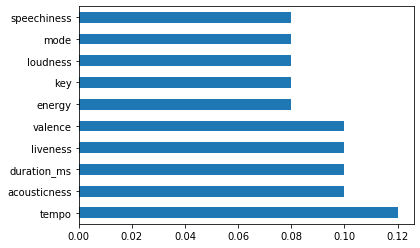

In [48]:
model = ExtraTreesClassifier()
model.fit(X,y)
features = pd.concat([pd.Series(temp_df.columns[1:]), pd.Series(model.feature_importances_)], axis=1)
features.columns = ['Features', 'Importance']
features = features.sort_values(by = 'Importance', ascending = False).reset_index().drop(['index'], axis = 1)
features
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [49]:
features

,Features,Importance
0,tempo,0.12
1,acousticness,0.10
2,duration_ms,0.10
3,liveness,0.10
4,valence,0.10
5,energy,0.08
6,key,0.08
7,loudness,0.08
8,mode,0.08
9,speechiness,0.08


## Feature Selection

In [18]:
X = df.iloc[:,1:]  #independent columns
y = df.iloc[:,0]

In [19]:
features_list = []
for i in range(10): 
    model = ExtraTreesClassifier()
    model.fit(X,y)
    features = model.feature_importances_ #use inbuilt class feature_importances of tree based classifiers
    features_list.append(features)


/Users/hyewonchung/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/hyewonchung/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/hyewonchung/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/hyewonchung/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Use

In [20]:
#getting mean of the feature selection process
means = pd.DataFrame({'1': pd.Series(features_list[0]), '2': pd.Series(features_list[1]), '3': pd.Series(features_list[2]),
             '4': pd.Series(features_list[3]), '5': pd.Series(features_list[4]), '6': pd.Series(features_list[5]), 
             '7': pd.Series(features_list[6]), '8': pd.Series(features_list[7]), '9': pd.Series(features_list[8]),
             '10': pd.Series(features_list[9])})
means['mean'] = means.mean(axis=1)
means

,1,2,3,4,5,6,7,8,9,10,mean
0,0.089016,0.092238,0.091946,0.090694,0.086050,0.091490,0.088866,0.085146,0.089448,0.088818,0.089371
1,0.090005,0.087249,0.087405,0.088864,0.090552,0.087294,0.088565,0.088379,0.090631,0.088311,0.088725
2,0.088199,0.089116,0.087202,0.088888,0.090014,0.088366,0.090128,0.088259,0.087831,0.088618,0.088662
3,0.091112,0.085961,0.088569,0.093887,0.089016,0.088688,0.091248,0.092998,0.090359,0.091321,0.090316
4,0.077340,0.077752,0.078353,0.076709,0.082250,0.076256,0.075679,0.077600,0.079279,0.077911,0.077913
5,0.076147,0.073444,0.075999,0.072819,0.074025,0.075546,0.075527,0.077983,0.072897,0.074532,0.074892
6,0.089466,0.087679,0.086119,0.087475,0.086272,0.084577,0.089624,0.090075,0.091423,0.091522,0.088423
7,0.089905,0.087784,0.087931,0.088124,0.088457,0.085665,0.090761,0.087250,0.091245,0.085629,0.088275
8,0.019430,0.015899,0.017687,0.012472,0.016302,0.019829,0.015474,0.015745,0.010250,0.016041,0.015913
9,0.088564,0.086541,0.085705,0.086149,0.086410,0.088295,0.086517,0.085908,0.089279,0.086867,0.087024


In [21]:
features = pd.concat([pd.Series(df.columns[1:]), means['mean']], axis=1)
features.columns = ['Features', 'Importance']
features = features.sort_values(by = 'Importance', ascending = False).reset_index().drop(['index'], axis = 1)

In [22]:
features

,Features,Importance
0,energy,0.090316
1,tempo,0.090170
2,valence,0.089724
3,acousticness,0.089371
4,danceability,0.088725
5,duration_ms,0.088662
6,liveness,0.088423
7,loudness,0.088275
8,speechiness,0.087024
9,instrumentalness,0.077913


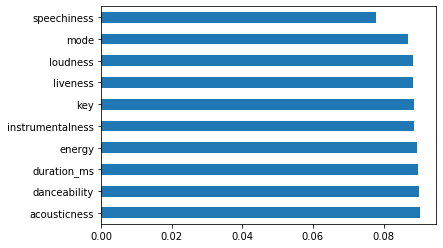

In [23]:
feat_importances = pd.Series(features.Importance.values, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()